In [1]:
# load libraries and scripts
import JSON
using Plots
using HDF5
using Trapz
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")

get_params (generic function with 5 methods)

In [2]:
#load borders
border = import_border("../data/border.json")

# create the lattice grid
dx = 20
Nx, Ny, xrange, yrange, isinside, isborder, n = get_grid(border, Float64(dx))

# define x and y coordinate for plotting
x = repeat(reshape(xrange,1,Nx), Ny, 1)
y = repeat(reshape(yrange,Ny,1), 1, Nx);

In [30]:
# compute or load grid parameters
recompute_param = true
sigma = 50.
if(recompute_param || isfile("../numerics/grid_params_" * string(dx) * ".h5"))
    bx, by, p, m, d = get_params(isinside, isborder, sigma, Float64(dx), yrange, xrange, "../data/pantagruel.h5",
        "../numerics/grid_params_" * string(dx) * ".h5")
else
    bx, by, p, m, d = get_params(isinside, "../numerics/grid_params_" * string(dx) * ".h5")
end

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [31]:
trapz((yrange,xrange), m)

181.46574099999998

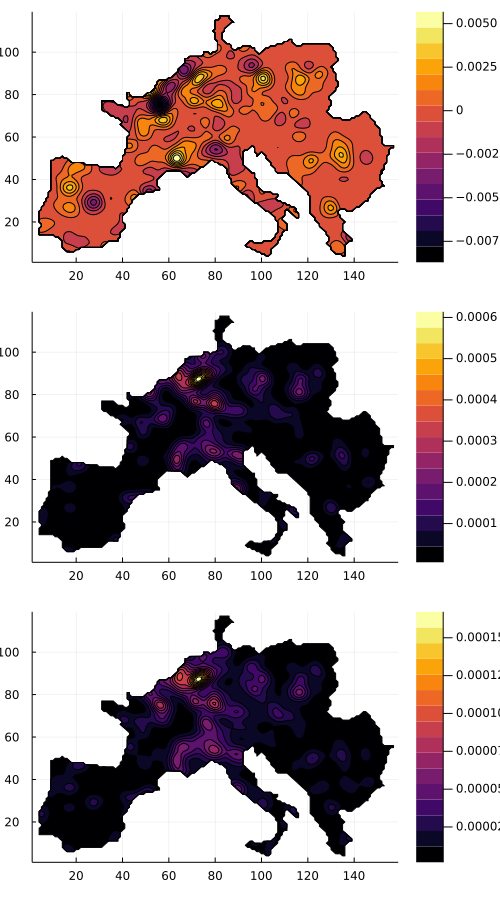

In [32]:
# plot some physical quantities
plot(do_plot(isinside, p), do_plot(isinside, m), do_plot(isinside, d), layout=(3,1), size=(500,900))


In [33]:
println(minimum(m[isinside]))
println(minimum(d[isinside]))

6.136022997508766e-6
1.6714178795261753e-6


In [5]:
# compute, iteratively, the stable solution
interval = 1000
Niter = 40000
th = zeros(Ny, Nx)

@time begin
    for k in 1:Niter
        if(mod(k,interval) == 0)
            temp = copy(th)
        end
        Threads.@threads for i in 2:Ny-1
            Threads.@threads for j in 2:Nx-1
                if(isinside[i,j])
                    bij = (by[i-1,j] + by[i,j] + bx[i,j] + bx[i,j+1])
                    th[i,j] = (by[i,j] * th[i+1,j] + by[i-1,j] * th[i-1,j] + 
                        bx[i,j+1] * th[i,j+1] + bx[i,j] * th[i,j-1] + dx^2*p[i,j]) / bij
                end
            end
        end
        Threads.@threads for k in 1:size(n,1)
            i = Int64(n[k,1])
            j = Int64(n[k,2])
            nx = n[k,4]
            ny = n[k,3]
            if(nx == 1)
                th[i,j] = th[i,j-2]
            elseif(nx == -1)
                th[i,j] = th[i,j+2]
            end
            if(ny == 1)
                th[i,j] = th[i-2,j]
            elseif(ny == -1)
                th[i,j] = th[i+2,j]
            end
        end  
        if(mod(k,interval) == 0)
            println([k maximum(abs.(th-temp))])
        end

    end
end


[1000.0 0.0003429313683688817]
[2000.0 0.00010093807929459353]
[3000.0 6.275837636410264e-5]
[4000.0 3.981914767031691e-5]
[5000.0 3.146527434996771e-5]
[6000.0 2.481738225457164e-5]
[7000.0 1.8995962992401916e-5]
[8000.0 1.4134628311707198e-5]
[9000.0 1.0690596143225761e-5]
[10000.0 9.297359430560093e-6]
[11000.0 8.20590879613281e-6]
[12000.0 7.3378887720521035e-6]
[13000.0 6.639994307722219e-6]
[14000.0 6.0738040502661406e-6]
[15000.0 5.610281172518938e-6]
[16000.0 5.22773012057165e-6]
[17000.0 4.909934581687203e-6]
[18000.0 4.646925584939066e-6]
[19000.0 4.433052215813138e-6]
[20000.0 4.290057568967498e-6]
[21000.0 4.1727500638688575e-6]
[22000.0 4.079776951271263e-6]
[23000.0 3.9919568582957865e-6]
[24000.0 3.906519059015956e-6]
[25000.0 3.842842383944278e-6]
[26000.0 3.834968109989179e-6]
[27000.0 3.812333473407481e-6]
[28000.0 3.778197323334176e-6]
[29000.0 3.7352967061365927e-6]
[30000.0 3.6857908637943915e-6]
[31000.0 3.6313818539690512e-6]
[32000.0 3.57341002446554e-6]
[33000.

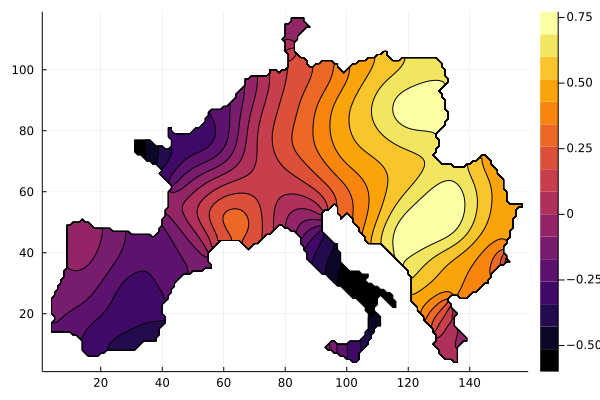

In [6]:
# plot the result
do_plot(isinside, th)

In [7]:
# save the result
fid = h5open("../numerics/stable_" * string(dx) * ".h5", "w")
write(fid, "th", th)
close(fid)